In [519]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re
from nltk.probability import FreqDist
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [520]:
pd.set_option=("display.max_colwidth",'100')
df1=pd.read_csv("../report1.csv")
df1.tail()

,type,summary,product,comp,assignee,status,resolution,updated
9995,NaN,Add gradle support for building gecko binaries...,Firefox Build System,Android Studio and G,nobody,NEW,---,2022-10-11
9996,NaN,Changing the orientation after swiping left a ...,Firefox for iOS,Home screen,nobody,NEW,---,2022-10-11
9997,NaN,"Incorrect focus on ""input"" name fields",Firefox,WebPayments UI,nobody,NEW,---,2022-10-11
9998,NaN,Enable sccache by default when available,Firefox Build System,General,nobody,NEW,---,2022-10-11
9999,NaN,Carthage is building for armv7 which we no lon...,Firefox for iOS,Build & Test,nobody,NEW,---,2022-10-11


In [521]:
df2 = df1.drop(['type','resolution','status','assignee'],axis = 1)
df2['summary'] = df2['summary'].str.lower()
df2['product'] = df2['product'].str.strip()
df3 = df2
df3.head()

,summary,product,comp,updated
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16


## Remove Punctuation

In [522]:
import string

string.punctuation

# Create a function to remove punctuation
def remove_punctuation(txt):
    txt_nopunt="".join([c for c in txt if c not in string.punctuation])
    return txt_nopunt

df3['msg_clean'] = df3['summary'].apply(lambda x:remove_punctuation(x))
df3.head()

,summary,product,comp,updated,msg_clean
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,firefox on ubuntu new tab crashes
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable fido ctap2 support in firefox nightly ...
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,firefox prompts two master password dialogs du...
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator blocks access to menu...
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,firefox prioritizes web socket events over loc...


## Tokenize the msg_clean

In [523]:
import re

def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens

df3['summary_tokenized'] = df3['msg_clean'].apply(lambda x: tokenize(x.lower()))

df3.head()

,summary,product,comp,updated,msg_clean,summary_tokenized
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,firefox on ubuntu new tab crashes,"[firefox, on, ubuntu, new, tab, crashes, ]"
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable fido ctap2 support in firefox nightly ...,"[enable, fido, ctap2, support, in, firefox, ni..."
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,firefox prompts two master password dialogs du...,"[firefox, prompts, two, master, password, dial..."
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator blocks access to menu...,"[global, sharing, indicator, blocks, access, t..."
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,firefox prioritizes web socket events over loc...,"[firefox, prioritizes, web, socket, events, ov..."


## Using nltk to remove stopwords from tokenized summary

In [524]:
import nltk

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(txt_tokenized):
    txt_clean = [word for word in txt_tokenized if word not in stopwords]
    return txt_clean

df3['no_swds'] = df3['summary_tokenized'].apply(lambda x: remove_stopwords(x))
df3.head()

[nltk_data] Downloading package stopwords to /home/taj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,summary,product,comp,updated,msg_clean,summary_tokenized,no_swds
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,firefox on ubuntu new tab crashes,"[firefox, on, ubuntu, new, tab, crashes, ]","[firefox, ubuntu, new, tab, crashes, ]"
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable fido ctap2 support in firefox nightly ...,"[enable, fido, ctap2, support, in, firefox, ni...","[enable, fido, ctap2, support, firefox, nightl..."
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,firefox prompts two master password dialogs du...,"[firefox, prompts, two, master, password, dial...","[firefox, prompts, two, master, password, dial..."
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator blocks access to menu...,"[global, sharing, indicator, blocks, access, t...","[global, sharing, indicator, blocks, access, m..."
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,firefox prioritizes web socket events over loc...,"[firefox, prioritizes, web, socket, events, ov...","[firefox, prioritizes, web, socket, events, lo..."


## Lemmatizing the no_swds to get the root word or 'Lemma'

First, we will create three methods to keep only the meaningful words, to remove numbers from the words, lemmatize the words.

In [525]:
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')
wn = nltk.WordNetLemmatizer()

# Define a function to check if a word has a dictionary meaning. Input: word
def word_has_dictionary_meaning(word):
    synsets = wordnet.synsets(word)
    return len(synsets) > 0

# Define a function to check if a word has a dictionary meaning. Input: array of words as token
def token_has_dictionary_meaning(token_txt):
    text = [word for word in token_txt if len(wordnet.synsets(word)) > 0]
    return text

# Define a function to remove numbers because there are many words that are basically numbers.
# Input: array of words as token
def clean_numbers(token_txt):
    number_pattern = r'^-?\d+$'
    text = [word for word in token_txt if not re.match(number_pattern, word)]
    return text

# Define a function to lemmatize words. Input: array of words as token
def lemmatization(token_txt):
    text = [wn.lemmatize(word) for word in token_txt]
    return text

[nltk_data] Downloading package wordnet to /home/taj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/taj/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Clean numbers and remove meaningless words
Warning!! This will get rid off many words such as Ubuntu, v8, x86, ... etc.

In [526]:
df3['meaningful_wrds'] = df3['no_swds'].apply(lambda token: token_has_dictionary_meaning(token)).apply(lambda token: clean_numbers(token))
#df3['meaningful_wrds'].head()

### Lemmatize words and convert array of words into string

In [527]:
df3['meaningful_lemm_wrds'] = df3['meaningful_wrds'].apply(lambda x: lemmatization(x))
df3['meaningful_lemm_str'] = df3['meaningful_lemm_wrds'].apply(lambda x: ' '.join(x))
#df3.head()

### Drop few more words

In [528]:
from nltk.corpus import stopwords

# Define stop words to remove them from TFIDF matrix
stop = list(stopwords.words('english'))
stop.extend(['10','13','30','60','firefox','doesnt','using','user','use','new','zoomoutcur','x','xx','xxx','xxxx', 
             'xyz','äöü','类型','更新10101之后','没有找到支持的视频格式和','类','型','1st','2d','2nd','3d','3rd','aa'])

## TF-IDF Matrix

In [529]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=25, max_features=20000)
# Create an instance of TfidfVectorizer with stop words
vectorizer = TfidfVectorizer(stop_words = stop)
# Fit and transform your text data using the vectorizer
tfidf_matrix = vectorizer.fit_transform(df3['meaningful_lemm_str'])

### Remove terms below a given threshold

In [530]:
mean_tfidf_scores = np.mean(tfidf_matrix, axis=0).A

# Set threshold
threshold = 0.01

# Get the feature names (i.e., words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()
feature_names = [feat for feat, score in zip(feature_names, mean_tfidf_scores.tolist()[0]) if score >= 0.01]

# Reconstruct TF-IDF matrix
filtered_tfidf_matrix = tfidf_matrix[:, [vectorizer.vocabulary_[feat] for feat in feature_names]]

### Plot TF-IDF Matrix

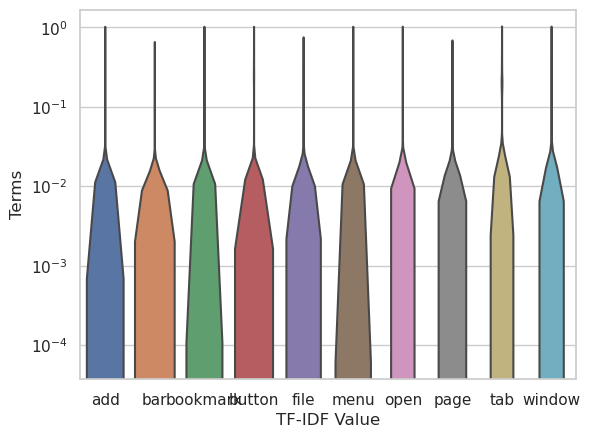

In [531]:
# We will use seaborn to create all plots
import seaborn as sns
import matplotlib.pyplot as plt

# Convert TF-IDF matrix to dense array
tfidf_matrix_dense = tfidf_matrix.toarray()

# Create an empty object
o_tfidf = {}

for i in range(len(df3)):
    for j, word in enumerate(feature_names):
        if word not in o_tfidf:
            o_tfidf[word] = []
        tfidf_score = filtered_tfidf_matrix[i, j]
        o_tfidf[word].append(tfidf_score)

# Convert object to data frame
df_tfidf = pd.DataFrame(o_tfidf)
                    
# Set the style of the plot (optional)
sns.set(style="whitegrid")

plt.yscale('log')
#plt.figure(figsize=(12, 8))
# Create the violin plot
#sns.violinplot(data=df_tfidf, orient="h", palette="Set2")
#sns.swarmplot(data=df_tfidf)
sns.violinplot(data=df_tfidf)

# Set labels for the axes (optional)
plt.xlabel("TF-IDF Value")
plt.ylabel("Terms")

# Show the plot
plt.show()

## Scatter plot TF-IDF score

In [502]:
# Scatter plot
#plt.scatter(df_tfidf)

# Labeling the axes and adding a title
#plt.xlabel('Features')
#plt.ylabel('TF-IDF Score')
#plt.title('Scatter Plot: TF-IDF Score of the Features')

# Show the plot
#plt.show()

## Observe the Elbow curve

/home/taj/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


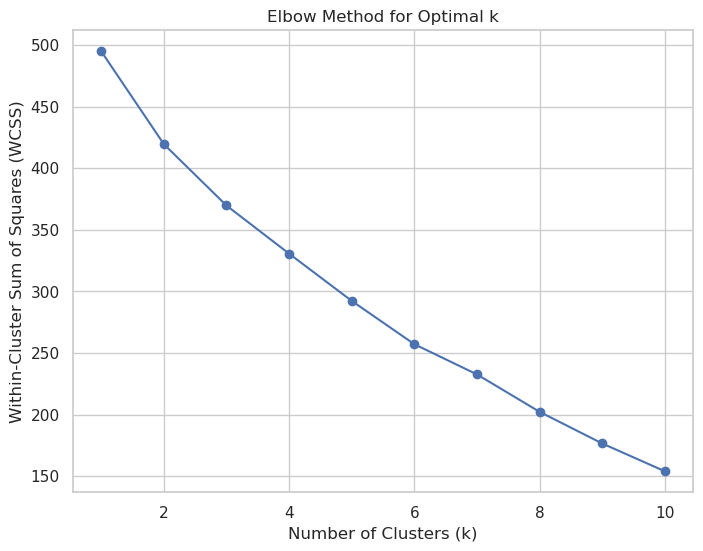

In [503]:
from sklearn.cluster import KMeans

# Initialize an empty list to store the within-cluster sum of squares (WCSS) values
wcss = []

# Create a range of values for k (number of clusters)
k_range = range(1, 11)

# Calculate WCSS for different values of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(filtered_tfidf_matrix)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

### Observe silhouette_score

In [389]:
#from sklearn.metrics import silhouette_score
#
#silhouette_scores = []
#k_range = range(2, 20)
#
#for k in k_range:
#    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
#    labels = kmeans.fit_predict(tfidf_matrix)
#    silhouette_avg = silhouette_score(tfidf_matrix, labels)
#    silhouette_scores.append(silhouette_avg)
#
## Plot silhouette scores
#plt.figure(figsize=(8, 6))
#plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
#plt.title('Silhouette Score for Optimal k')
#plt.xlabel('Number of Clusters (k)')
#plt.ylabel('Silhouette Score')
#plt.grid(True)
#plt.show()

## K-Means Clustering

In [504]:
# Define the number of clusters
num_clusters = 3

# Define the initialization method for the centroids
random = 'k-means++'

# Define the maximum number of iterations for the algorithm
max_iter = 1000

# Define the random state for reproducibility
random_state = 42

# Define n_init
n_init = 10

# Create a KMeans object with the defined parameters
km = KMeans(n_clusters=num_clusters, init=random, max_iter=max_iter, random_state=random_state, n_init=n_init)

# Fit the KMeans model to the TF-IDF matrix
km.fit(tfidf_matrix)

# Get the cluster labels for each document
cluster_labels = km.labels_

# Print the cluster labels for each document
#for i, label in enumerate(cluster_labels):
#    print(f"Document: {i+1} -- Cluster: {label}")


### Get the word-cloud from the clusters

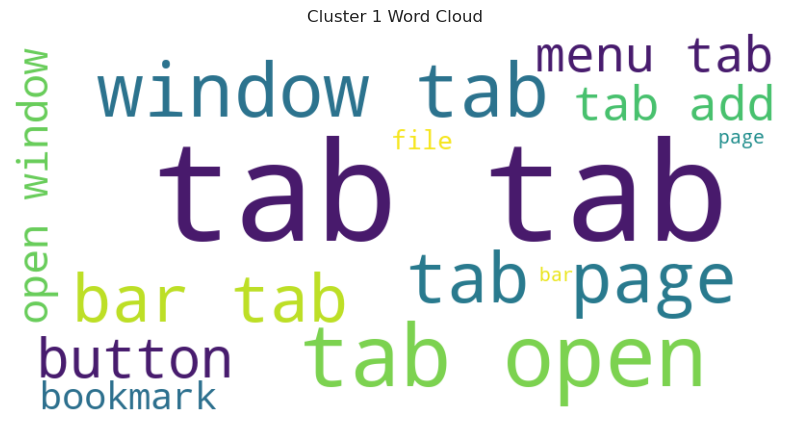

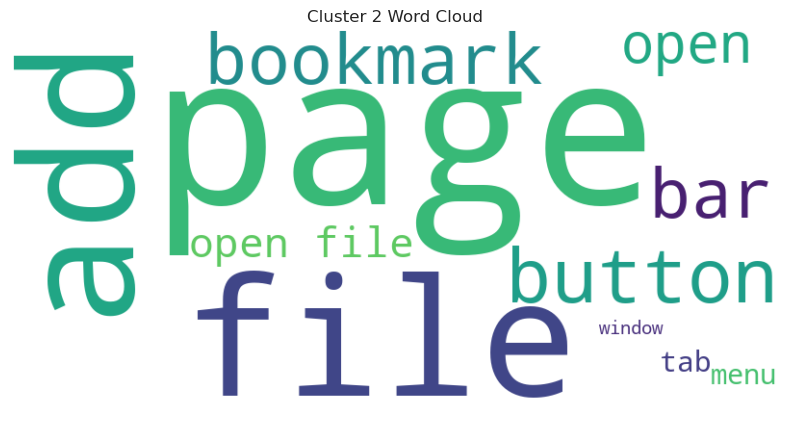

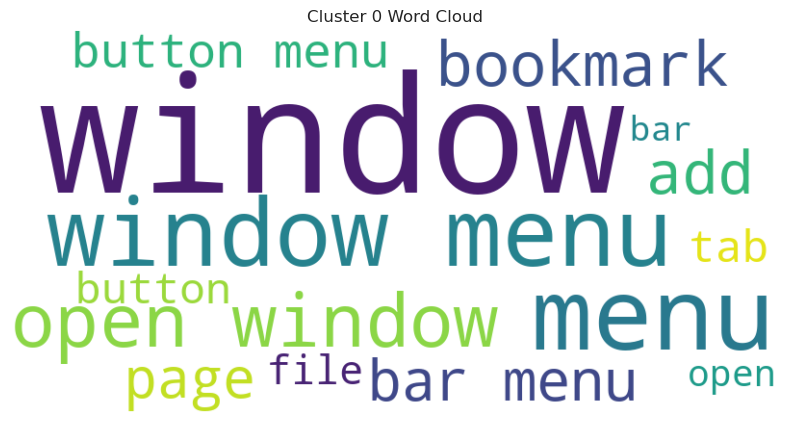

In [506]:
#pip install wordcloud
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary to store the documents in each cluster
cluster_docs = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_docs:
        cluster_docs[label] = []
    cluster_docs[label].append(i)

# Create word cloud for each cluster
for label, doc_indices in cluster_docs.items():
    # Retrieve the words from the TfidfVectorizer object
    cluster_words = " ".join(feature_names[i] for i in filtered_tfidf_matrix[doc_indices].nonzero()[1])

    # Check if cluster contains at least one document with words
    if cluster_words:
        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(cluster_words)

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Cluster {label} Word Cloud')
        plt.axis('off')
        plt.show()
    else:
        print(f"No documents with words in Cluster {label}")



In [507]:
from sklearn.cluster import KMeans

# create KMeans clustering object
kmeans = KMeans(n_clusters=num_clusters, random_state=random_state, n_init=n_init)

# fit KMeans clustering model to the tfidf_matrix
kmeans.fit(tfidf_matrix)

# get cluster labels for each row in the tfidf_matrix
df3['cluster_labels'] = kmeans.labels_

# print number of rows in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 1176, 1: 1174, 2: 7650}


### PCA Reduced

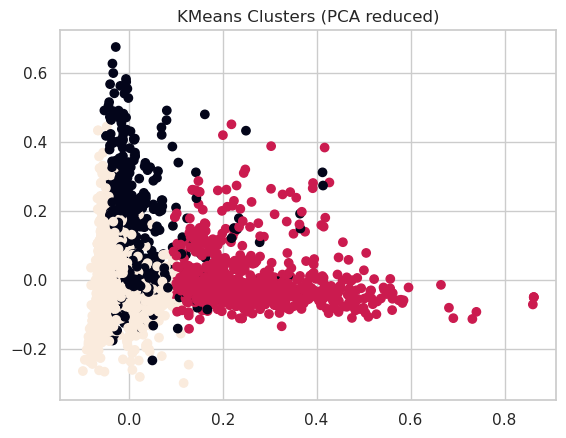

In [508]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of tfidf matrix using PCA
pca = PCA(n_components = 3)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Plot the documents in 2D space, coloring the points according to their cluster labels
plt.scatter(tfidf_matrix_reduced[:, 0], tfidf_matrix_reduced[:, 2], c=cluster_labels)
plt.title("KMeans Clusters (PCA reduced)")
plt.show()


## DB Scan Clustering

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram


In [142]:
# Get the feature names from the TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the centroid vectors for each cluster
centroids = km.cluster_centers_

# Get the indices of the most important features for each cluster
important_indices = centroids.argsort()[:, ::-1]

# Get the most important words for each cluster
num_words = 15
cluster_labels = {}
for i in range(num_clusters):
    label = f"Cluster {i+1}: "
    for j in range(num_words):
        label += feature_names[important_indices[i][j]] + ", "
    cluster_labels[i] = label[:-2]

# Print the cluster labels
for i, label in cluster_labels.items():
    print(label)


Cluster 1: file, error, button, download, work, browser, update, open, default, text, sync, show, meta, crash, site
Cluster 2: menu, add, test, context, intermittent, timed, item, automated, option, button, top, found, support, search, platform
Cluster 3: page, tab, web, loading, home, load, error, save, button, blank, back, show, reload, option, content
Cluster 4: bookmark, toolbar, folder, menu, panel, sync, library, button, tab, icon, tag, show, add, bar, open
Cluster 5: tab, open, close, link, opening, closing, opened, button, switch, pinned, show, current, closed, option, restore
Cluster 6: display, pdf, file, viewer, window, image, print, page, icon, document, wrong, download, render, default, content
Cluster 7: window, open, tab, 10, private, close, menu, monitor, closed, button, opening, screen, setting, browser, option
Cluster 8: bar, address, search, url, location, tab, menu, window, title, button, scroll, text, screen, page, top


In [92]:
df4=df3.drop(['msg_clean','summary_tokenized','no_swds','lemmatized_wrds'],axis=1)
df4

,summary,product,comp,updated,lemmatized_str,cluster_labels
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,firefox ubuntu new tab crash,0
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable fido ctap2 support firefox nightly,0
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,firefox prompt two master password dialog star...,0
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator block access menu macos,0
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,firefox prioritizes web socket event location ...,0
...,...,...,...,...,...,...
9995,add gradle support for building gecko binaries...,Firefox Build System,Android Studio and G,2022-10-11,add gradle support building gecko binary,0
9996,changing the orientation after swiping left a ...,Firefox for iOS,Home screen,2022-10-11,changing orientation swiping left home panel i...,0
9997,"incorrect focus on ""input"" name fields",Firefox,WebPayments UI,2022-10-11,incorrect focus input name field,0
9998,enable sccache by default when available,Firefox Build System,General,2022-10-11,enable sccache default available,0


In [93]:
#labels_map = {0: "Browser Functionality", 1: "Security", 2: "User Interface"}
#df4['cluster_labels'] = df4['cluster_labels'].replace(labels_map)
df4.tail(70)

,summary,product,comp,updated,lemmatized_str,cluster_labels
9930,move the payment summary page its own custom e...,Firefox,WebPayments UI,2022-10-11,move payment summary page custom element clean...,0
9931,[remote-dbg-next] add mochitest to test naviga...,DevTools,about:debugging,2022-10-11,remotedbgnext add mochitest test navigation th...,0
9932,restore all tabs doesn't work when the only ta...,Firefox,Session Restore,2022-10-11,restore tab doesnt work tab thats open new tab,0
9933,figure out why we need translatefragment for t...,Firefox,Settings UI,2022-10-11,figure need translatefragment space alert noti...,0
9934,msi configured taskbar_shortcut is not applied...,Firefox,Installer,2022-10-11,msi configured taskbarshortcut applied win 7wi...,0
...,...,...,...,...,...,...
9995,add gradle support for building gecko binaries...,Firefox Build System,Android Studio and G,2022-10-11,add gradle support building gecko binary,0
9996,changing the orientation after swiping left a ...,Firefox for iOS,Home screen,2022-10-11,changing orientation swiping left home panel i...,0
9997,"incorrect focus on ""input"" name fields",Firefox,WebPayments UI,2022-10-11,incorrect focus input name field,0
9998,enable sccache by default when available,Firefox Build System,General,2022-10-11,enable sccache default available,0


In [94]:
# Assuming df4 is the existing DataFrame and cluster_labels is the dictionary with cluster labels

# Create the cluster columns with empty values
df4['cluster1'] = ''
df4['cluster2'] = ''
#df4['cluster3'] = ''

# Populate the cluster columns based on the existence of cluster words in the summary
for i in range(len(df4)):
    summary = df4.loc[i, 'summary']
    for j in range(num_clusters):
        cluster_words = cluster_labels[j].replace(f"Cluster {j+1}: ", "").split(", ")
        for word in cluster_words:
            if word.lower() in summary.lower():
                if j == 0:
                    df4.loc[i, 'cluster1'] += f"{word}, "
                elif j == 1:
                    df4.loc[i, 'cluster2'] += f"{word}, "
                #elif j == 2:
                #    df4.loc[i, 'cluster3'] += f"{word}, "

# Remove trailing commas from the cluster columns
df4['cluster1'] = df4['cluster1'].str.rstrip(", ")
df4['cluster2'] = df4['cluster2'].str.rstrip(", ")
#df4['cluster3'] = df4['cluster3'].str.rstrip(", ")

# Print the updated DataFrame
print(df4)




                                                summary               product  \
0             firefox on ubuntu new tab crashes                          Core   
1     enable fido ctap2 support in firefox nightly  ...                  Core   
2     firefox prompts two master password dialogs du...               Toolkit   
3     global sharing indicator blocks access to menu...               Firefox   
4     firefox prioritizes web socket events over loc...                  Core   
...                                                 ...                   ...   
9995  add gradle support for building gecko binaries...  Firefox Build System   
9996  changing the orientation after swiping left a ...       Firefox for iOS   
9997     incorrect focus on "input" name fields                       Firefox   
9998   enable sccache by default when available          Firefox Build System   
9999  carthage is building for armv7 which we no lon...       Firefox for iOS   

                           

In [95]:
df4.head(50)

,summary,product,comp,updated,lemmatized_str,cluster_labels,cluster1,cluster2
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,firefox ubuntu new tab crash,0,tab,tab
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable fido ctap2 support firefox nightly,0,,
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,firefox prompt two master password dialog star...,0,,
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator block access menu macos,0,menu,menu
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,firefox prioritizes web socket event location ...,0,,
5,[e10s-multi] firefox 55 breaks tabs & session ...,Core,General,2022-10-11,e10smulti firefox 55 break tab session high nu...,0,tab,"tab, 10"
6,show tab favicons immediately,Firefox,Tabbed Browser,2022-10-28,show tab favicons immediately,0,"tab, show",tab
7,glib-gobject-critical starting firefox,Core,Widget: Gtk,2022-10-11,glibgobjectcritical starting firefox,0,,
8,firefox 57 video lags when some content loaded...,Core,Audio/Video: Playbac,2022-10-11,firefox 57 video lag content loaded background...,0,tab,tab
9,firefox does not load videos fully,Core,Audio/Video: Playbac,2022-10-11,firefox load video fully,0,,


In [96]:
# Create the 'common_words' column
df4['common_words'] = ''

# Iterate over each row
for i, row in df4.iterrows():
    # Get the values from cluster columns
    cluster1_words = row['cluster1'].split(", ")
    cluster2_words = row['cluster2'].split(", ")
    #cluster3_words = row['cluster3'].split(", ")

    # Initialize a list to store common words
    common_words = []

    # Check for common words between cluster1 and cluster2
    for word1 in cluster1_words:
        for word2 in cluster2_words:
            if word1 == word2:
                # Add the common word to the list
                common_words.append(word1)

    # Check for common words between cluster1 and cluster3
    #for word1 in cluster1_words:
    #    for word3 in cluster3_words:
    #        if word1 == word3:
    #            # Add the common word to the list
    #            common_words.append(word1)

    # Check for common words between cluster2 and cluster3
    #for word2 in cluster2_words:
    #    for word3 in cluster3_words:
    #        if word2 == word3:
    #            # Add the common word to the list
    #            common_words.append(word2)

    # Remove duplicate words from the common_words list
    common_words = list(set(common_words))

    # Populate the 'common_words' column
    df4.at[i, 'common_words'] = ", ".join(common_words)

# Print the updated DataFrame
print(df4)

                                                summary               product  \
0             firefox on ubuntu new tab crashes                          Core   
1     enable fido ctap2 support in firefox nightly  ...                  Core   
2     firefox prompts two master password dialogs du...               Toolkit   
3     global sharing indicator blocks access to menu...               Firefox   
4     firefox prioritizes web socket events over loc...                  Core   
...                                                 ...                   ...   
9995  add gradle support for building gecko binaries...  Firefox Build System   
9996  changing the orientation after swiping left a ...       Firefox for iOS   
9997     incorrect focus on "input" name fields                       Firefox   
9998   enable sccache by default when available          Firefox Build System   
9999  carthage is building for armv7 which we no lon...       Firefox for iOS   

                           

In [97]:
df4.head(50)

,summary,product,comp,updated,lemmatized_str,cluster_labels,cluster1,cluster2,common_words
0,firefox on ubuntu new tab crashes,Core,Widget: Gtk,2022-07-11,firefox ubuntu new tab crash,0,tab,tab,tab
1,enable fido ctap2 support in firefox nightly ...,Core,DOM: Web Authenticat,2022-10-26,enable fido ctap2 support firefox nightly,0,,,
2,firefox prompts two master password dialogs du...,Toolkit,Password Manager,2022-09-28,firefox prompt two master password dialog star...,0,,,
3,global sharing indicator blocks access to menu...,Firefox,Site Permissions,2021-08-28,global sharing indicator block access menu macos,0,menu,menu,menu
4,firefox prioritizes web socket events over loc...,Core,DOM: Networking,2021-11-16,firefox prioritizes web socket event location ...,0,,,
5,[e10s-multi] firefox 55 breaks tabs & session ...,Core,General,2022-10-11,e10smulti firefox 55 break tab session high nu...,0,tab,"tab, 10",tab
6,show tab favicons immediately,Firefox,Tabbed Browser,2022-10-28,show tab favicons immediately,0,"tab, show",tab,tab
7,glib-gobject-critical starting firefox,Core,Widget: Gtk,2022-10-11,glibgobjectcritical starting firefox,0,,,
8,firefox 57 video lags when some content loaded...,Core,Audio/Video: Playbac,2022-10-11,firefox 57 video lag content loaded background...,0,tab,tab,tab
9,firefox does not load videos fully,Core,Audio/Video: Playbac,2022-10-11,firefox load video fully,0,,,


In [98]:
# Filter rows where common_words column is not empty and not just empty spaces
df5 = df4[df4['common_words'].str.strip() != '']

# Sort the DataFrame by common_words column in alphabetical order
df5 = df5.sort_values(by='common_words')

df5



,summary,product,comp,updated,lemmatized_str,cluster_labels,cluster1,cluster2,common_words
4874,bookmark toolbar separators not consistent in ...,Firefox,Theme,2022-10-11,bookmark toolbar separator consistent appearan...,0,"bookmark, bar",bar,bar
8684,standardize color of extension icons in locati...,Firefox,Site Identity,2022-10-11,standardize color extension icon location bar ...,0,bar,bar,bar
2824,vertical space user interface improvement: flo...,Firefox,Toolbars and Customi,2022-10-10,vertical space user interface improvement floa...,0,"bookmark, bar",bar,bar
8652,suspend the taskbar refresh in windowsjumplist...,Firefox,General,2022-10-11,suspend taskbar refresh windowsjumplistsjsm co...,0,bar,"window, bar",bar
2871,toolbars not disappearing in fullscreen on pop...,Firefox,Toolbars and Customi,2022-10-10,toolbars disappearing fullscreen popups,0,bar,"bar, screen",bar
...,...,...,...,...,...,...,...,...,...
9199,click on previous/last page button while holdi...,Firefox,Tabbed Browser,2022-10-11,click previouslast page button holding ctrl do...,0,"tab, page, button, open","tab, open, button","tab, open, button"
493,sync back button history when syncing/sending ...,Firefox,Sync,2022-10-11,sync back button history syncingsending open t...,0,"tab, button, open","tab, open, button, browser","tab, open, button"
1947,"with the middle click, open the tab on mouse b...",Firefox,Tabbed Browser,2022-10-10,middle click open tab mouse button,0,"tab, button, open","tab, open, button","tab, open, button"
9826,reopen last closed tab button,Firefox for iOS,Browser,2022-11-01,reopen last closed tab button,0,"tab, button, open","tab, open, close, button","tab, open, button"


In [99]:
df5_sorted = df5.sort_values('cluster_labels')
df5_sorted.tail(50)


,summary,product,comp,updated,lemmatized_str,cluster_labels,cluster1,cluster2,common_words
7937,(e10s-specific) crashed tabs couldn't be resto...,Firefox,General,2022-10-11,e10sspecific crashed tab couldnt restored deta...,1,tab,"window, tab, 10",tab
4057,firefox menu button on wrong side after loadin...,Firefox,Toolbars and Customi,2022-10-10,firefox menu button wrong side loading window ...,1,"menu, file, button","window, menu, button","menu, button"
7987,sidebars are not properly displayed in new pri...,Firefox,Private Browsing,2022-10-11,sidebar properly displayed new private window,1,bar,"window, private, bar",bar
3763,if drag & drop a tab out firefox to generate a...,Firefox,Tabbed Browser,2022-10-10,drag drop tab firefox generate new window drag...,1,"tab, bar","window, tab, bar","tab, bar"
4212,sidebar view doesn't obey the windows high-con...,Firefox,Theme,2022-10-11,sidebar view doesnt obey window highcontrast t...,1,bar,"window, bar",bar
5238,improve look of context menu on windows,Firefox,Menus,2022-10-11,improve look context menu window,1,menu,"window, menu",menu
88,hardware acceleration is making firefox tab ba...,Core,Graphics: WebRender,2022-10-10,hardware acceleration making firefox tab bar g...,1,"tab, bar","window, tab, 10, bar","tab, bar"
6813,http authentication with tab-modal shows last ...,Firefox,Security,2020-11-30,http authentication tabmodal show last page wi...,1,"tab, page, show","window, tab",tab
9939,a pinned tab doesn't remain pinned after is mo...,Firefox,Tabbed Browser,2022-10-11,pinned tab doesnt remain pinned moved another ...,1,tab,"window, tab",tab
3725,horizontal and vertical scroll bar missing whe...,Firefox,General,2022-10-10,horizontal vertical scroll bar missing window ...,1,bar,"window, 10, bar, size",bar


In [100]:
df5.to_csv('output.csv', index=False)


In [101]:
df5=pd.read_csv('output.csv')

In [102]:
df5.drop("updated",axis=1)

,summary,product,comp,lemmatized_str,cluster_labels,cluster1,cluster2,common_words
0,bookmark toolbar separators not consistent in ...,Firefox,Theme,bookmark toolbar separator consistent appearan...,0,"bookmark, bar",bar,bar
1,standardize color of extension icons in locati...,Firefox,Site Identity,standardize color extension icon location bar ...,0,bar,bar,bar
2,vertical space user interface improvement: flo...,Firefox,Toolbars and Customi,vertical space user interface improvement floa...,0,"bookmark, bar",bar,bar
3,suspend the taskbar refresh in windowsjumplist...,Firefox,General,suspend taskbar refresh windowsjumplistsjsm co...,0,bar,"window, bar",bar
4,toolbars not disappearing in fullscreen on pop...,Firefox,Toolbars and Customi,toolbars disappearing fullscreen popups,0,bar,"bar, screen",bar
...,...,...,...,...,...,...,...,...
3219,click on previous/last page button while holdi...,Firefox,Tabbed Browser,click previouslast page button holding ctrl do...,0,"tab, page, button, open","tab, open, button","tab, open, button"
3220,sync back button history when syncing/sending ...,Firefox,Sync,sync back button history syncingsending open t...,0,"tab, button, open","tab, open, button, browser","tab, open, button"
3221,"with the middle click, open the tab on mouse b...",Firefox,Tabbed Browser,middle click open tab mouse button,0,"tab, button, open","tab, open, button","tab, open, button"
3222,reopen last closed tab button,Firefox for iOS,Browser,reopen last closed tab button,0,"tab, button, open","tab, open, close, button","tab, open, button"


In [103]:
df5.to_csv('output1.csv', index=False)